<a href="https://colab.research.google.com/github/shahin1009/EDMD/blob/main/EDMDc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [184]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

plt.rcParams['figure.figsize'] = (5, 4)

In [185]:
# Unforced
def f(q, t):
    x, y = q
    return [y, x-x**3]


def forcing(t):
    return 2 * np.sin(2 * np.pi * 0.1 * t) * np.sin(2 * np.pi * 1 * t)

def ff(q, t):
    x, y = q
    return [y, x-x**3+forcing(t)] 

def solve(f , ic,t):
    sol = odeint(f, ic, t)
    return sol



In [186]:
t = np.linspace(0, 10, 1000)
dt=t[1]-t[0]
x0 = np.array([0, -2.8])
y=solve(f,x0,t)
yf = solve(ff,x0,t)
uf = forcing(t)

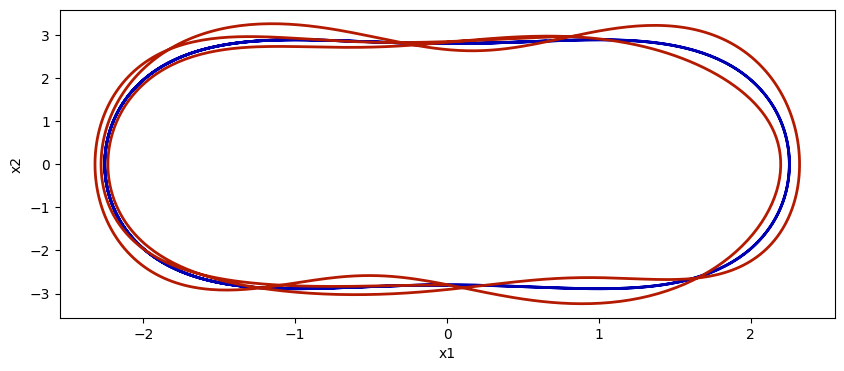

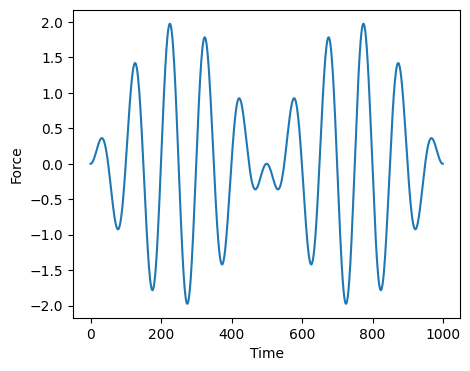

In [187]:
fig, ax1 = plt.subplots(figsize=(10, 4))  # Create a figure with two subplots

ax1.plot(y[:, 0], y[:, 1], '-', color=[0, 0, 0.7], linewidth=2)
ax1.plot(yf[:, 0], yf[:, 1], '-', color=[0.7, 0.1, 0], linewidth=2)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
plt.show()

fig3 = plt.figure()
plt.plot(uf)
plt.xlabel('Time')
plt.ylabel('Force')

plt.show()

In [188]:
def buildTheta(yin, nVars, polyorder):


    """
    Builds a polynomial dictionary from input data.

    Args:
        yin: Input data.
        nVars: Number of input variables.
        polyorder: Polynomial order.

    Returns:
        Polynomial dictionary.
    """
    n = yin.shape[0]
    ind = 0
    yout = np.zeros((n, nVars))

    # Copy input variables to output
    for i in np.arange(nVars):
        yout[:, ind] = yin[:, i]
        ind += 1


    if polyorder >= 2:
        # Polynomial order 2
        for i in np.arange(nVars):
            for j in np.arange(i, nVars):
                new_col = yin[:, i] * yin[:, j]
                yout = np.append(yout, new_col.reshape(-1, 1), 1)
    

    if polyorder >= 3:
        # Polynomial order 3
        for i in np.arange(nVars):
            for j in np.arange(i, nVars):
                for k in np.arange(j, nVars):
                    new_col = yin[:, i] * yin[:, j] * yin[:, k]
                    yout = np.append(yout, new_col.reshape(-1, 1), 1)
           
    if polyorder >= 4:
        # Polynomial order 4
        for i in np.arange(nVars):
            for j in np.arange(i, nVars):
                for k in np.arange(j, nVars):
                    for l in np.arange(k, nVars):
                        new_col = yin[:, i] * yin[:, j] * yin[:, k] * yin[:, l]
                        yout = np.append(yout, new_col.reshape(-1, 1), 1)
             


    return yout

In [194]:
yf

array([[ 0.        , -2.8       ],
       [-0.0280285 , -2.80013755],
       [-0.05605968, -2.80053918],
       ...,
       [ 0.78823764,  2.96458599],
       [ 0.81792779,  2.96745696],
       [ 0.84764513,  2.97001255]])

In [190]:
polyorder = 4
nvar = 2

Theta = buildTheta(yf, nvar, polyorder)
Theta = Theta.T
print(Theta.shape)
Nstates = Theta.shape[1]
G = np.append(Theta[:,:-1], uf[:-1].reshape(1, -1), 0)
print(G.shape)

(14, 1000)
(15, 999)


In [213]:
from scipy.linalg import svd , inv

Ug, Sg, Vg = svd(G, full_matrices=False)
print(Vg.shape)
print(Theta[:,1:].shape)
AB = Theta[:,1:] @ Vg.T @ inv(np.diag(Sg[:15])) @ Ug.T
Am = AB[:Nstates, :Nstates]
Bm = AB[:Nstates, -1]
Cm = np.eye(Nstates)
Dm = np.zeros((Nstates, 1))
Am

(15, 999)
(14, 999)


array([[ 1.00004983e+00,  1.00119293e-02, -9.72639354e-07,
         3.23275742e-07, -7.91925617e-08, -5.00426764e-05,
        -7.20713038e-07,  1.76487999e-08, -1.93840709e-07,
         2.02909555e-07, -2.62910535e-08,  4.51376642e-08,
        -3.80918099e-08,  1.31416378e-08,  5.01014758e-05],
       [ 9.92779095e-03,  1.00057510e+00, -2.91874100e-04,
         9.68733006e-05, -2.36060725e-05, -9.99231593e-03,
        -2.15947951e-04,  4.97142722e-06, -5.80853864e-05,
         6.08720279e-05, -7.86554660e-06,  1.35494696e-05,
        -1.14166604e-05,  3.92473035e-06,  1.00084892e-02],
       [ 2.32706133e-05, -1.94528301e-05,  1.00034274e+00,
         1.99946344e-02,  7.83257780e-05, -1.51463073e-06,
        -5.96931934e-06, -5.26672785e-06,  3.44904259e-06,
        -1.48312490e-04,  3.68589609e-06, -1.20968355e-05,
         2.00880996e-06,  2.02149292e-06,  4.77272315e-05],
       [ 2.34233980e-03, -1.85068366e-03,  3.41723125e-02,
         9.97774917e-01,  7.81469365e-03, -1.52108602

In [193]:
from scipy.signal import lsim
from scipy import signal

sysmodel_EDMDc = signal.StateSpace(Am, Bm, Cm, Dm, 0.001)

# yEDMDc = lsim(sysmodel_EDMDc, uF.T, tspan, X0=poolData(x0, 2, pEDMDc.polyorder, pEDMDc.usesine).T)[0]
# yEDMDc = yEDMDc[:, :2]

TypeError: ignored

In [ ]:
dt